# Quality Control

The purpose of this notebook is to QC the IEM Historical dataset that was processed. See the `process_iem_historical` notebook for a description of the data.

In [1]:
from config import output_dir
processed = [x for x in output_dir.glob("*CRU*.tif")]

## Metadata Consistent?

In [2]:
import rasterio as rio
import threading
import concurrent.futures

In [3]:
def metadata_check(fps):
    all_meta = []
    read_lock = threading.Lock()

    def process(fp):
        src = rio.open(fp)
        with read_lock:
            profile = src.profile
            all_meta.append(profile)
    
    # map the process() function over the list of files
    with concurrent.futures.ThreadPoolExecutor(
        max_workers=32
    ) as executor:
        executor.map(process, fps)

    return all_meta

In [4]:
meta = metadata_check(processed)

In [5]:
# there should be 115 years * 9 variables (minus 1901 talik thickness)
assert len(processed) == 115 * 9 -1 == len(meta)
# we should have one item in the metadata set
assert(all([x == meta[0] for x in meta]) == True)

## NoData Frequency Consistent?

We generally expect each GeoTIFF to contain the exact same number of NoData (-9999) values. There could be exceptions for some variables, for example if there is no Talik in some instances, is that value zero? Or is it NoData? This is also a good check to run because it will flag cases where a GeoTIFF was created that has valid metadata and appears on the surface to be a normal GeoTIFF, but is missing some or all of the data because of a write error or some other file corrupiton. In the past we've seen unexpected stripes or blocks that contain NoData values, but should contain actual data.


In [13]:
import numpy as np

def count_nodata_pixels(src):
    """This function will count the occcurences of the prescribed 'nodata' value in a raster.
    For example, a value of 10000 indicates that 10000 pixels have a nodata value."""
    arr = src.read(1)
    return np.sum((arr == src.meta["nodata"]) * 1)
    

def check_nodata_count(fps):
    all_nodata_counts = []
    read_lock = threading.Lock()

    def process(fp):
        src = rio.open(fp)
        with read_lock:
            all_nodata_counts.append(count_nodata_pixels(src))
    
    with concurrent.futures.ThreadPoolExecutor(
        max_workers=32
    ) as executor:
        executor.map(process, fps)

    return all_nodata_counts

In [14]:
nodata_counts = check_nodata_count(processed)

In [16]:
# make sure all files were checked
assert len(nodata_counts) == len(processed)
# set of nodata counts should have only 1 item
assert len(np.unique(nodata_counts)) == 1

## Plausible Values
We should also determine whether or not the values for each variable are bound within some plausible for range. For talik thickness, permafrost base, and permafrost top (all in units of meters) all values should be positive. A negative depth or thickness would not make sense in this context. The ground temperatures are likely bound between -20 and +20 degrees Celsius. The surface temperature likely has a broader range, -25 to +25 degrees Celsius is perhaps a good starting point. To test these assumptions we can extract miniumum and maximum values from each raster, and then determine whether or not those values fall within the expected ranges.

In [54]:
value_check_di = {}
permafrost_variables = sorted(list(set([x.name.split("_")[2] for x in processed])))
for var in permafrost_variables:
    value_check_di[var] = {}

value_check_di["magt0.5m"]["min"] = -20
value_check_di["magt0.5m"]["max"] = 20
    
value_check_di["magt1m"]["min"] = -20
value_check_di["magt1m"]["max"] = 20

value_check_di["magt2m"]["min"] = -20
value_check_di["magt2m"]["max"] = 20

value_check_di["magt3m"]["min"] = -20
value_check_di["magt3m"]["max"] = 20

value_check_di["magt5m"]["min"] = -20
value_check_di["magt5m"]["max"] = 20

value_check_di["magtsurface"]["min"] = -25
value_check_di["magtsurface"]["max"] = 25

# we actually do not know what the model "basement" is yet
# how deep is permafrost base, or talik thickness modeled?
# I am guessing 500 m for now as a max depth, but either way we will find out!
value_check_di["permafrostbase"]["min"] = 0
value_check_di["permafrostbase"]["max"] = 500

value_check_di["permafrosttop"]["min"] = 0
value_check_di["permafrosttop"]["max"] = 500

value_check_di["talikthickness"]["min"] = 0
value_check_di["talikthickness"]["max"] = 500

In [57]:
import dask
import dask.array as da
from dask import delayed

# define a delayed function to get min/max vals for a single GeoTIFF
@delayed
def compute_stats_for_file(file):
    with rio.open(file) as src:
        file_stats = {}
        arr = da.from_array(src.read(1))
        arr[arr == src.meta["nodata"]] = np.nan
        
        file_stats = {"filename": file.name,
                      "variable": file.name.split("_")[2],
                      "min_val": da.nanmin(arr).compute(),
                      "max_val": da.nanmax(arr).compute()}
    return file_stats

In [ ]:
from dask.distributed import Client
# create dask client
client = Client()
client

In [58]:
import random
random.seed(269)
# check a few random files
for x in range(15):
    x = dask.compute(compute_stats_for_file(random.choice(processed)))
    print(x)

({'filename': 'gipl_CRU-TS4.0_magt0.5m_degC_1985.tif', 'variable': 'magt0.5m', 'min_val': -22.304, 'max_val': 8.615},)
({'filename': 'gipl_CRU-TS4.0_magt1m_degC_1922.tif', 'variable': 'magt1m', 'min_val': -22.191, 'max_val': 8.666},)
({'filename': 'gipl_CRU-TS4.0_magt3m_degC_1940.tif', 'variable': 'magt3m', 'min_val': -21.173, 'max_val': 9.655},)
({'filename': 'gipl_CRU-TS4.0_permafrostbase_m_1918.tif', 'variable': 'permafrostbase', 'min_val': 0.0, 'max_val': 729.233},)
({'filename': 'gipl_CRU-TS4.0_magt3m_degC_1915.tif', 'variable': 'magt3m', 'min_val': -20.317, 'max_val': 9.903},)
({'filename': 'gipl_CRU-TS4.0_permafrosttop_m_1965.tif', 'variable': 'permafrosttop', 'min_val': 0.0, 'max_val': 29.858},)
({'filename': 'gipl_CRU-TS4.0_magt0.5m_degC_2002.tif', 'variable': 'magt0.5m', 'min_val': -21.723, 'max_val': 9.265},)
({'filename': 'gipl_CRU-TS4.0_magt1m_degC_1908.tif', 'variable': 'magt1m', 'min_val': -21.664, 'max_val': 8.809},)
({'filename': 'gipl_CRU-TS4.0_magtsurface_degC_1999.t

The initial assumptions about plausible value ranges were not far off, but based on this random sample we should make a few updates.

In [56]:
value_check_di["magt0.5m"]["min"] = -25
value_check_di["magt0.5m"]["max"] = 15
    
value_check_di["magt1m"]["min"] = -25
value_check_di["magt1m"]["max"] = 15

value_check_di["magt2m"]["min"] = -25
value_check_di["magt2m"]["max"] = 15

value_check_di["magt3m"]["min"] = -25
value_check_di["magt3m"]["max"] = 15

value_check_di["magt5m"]["min"] = -25
value_check_di["magt5m"]["max"] = 15

value_check_di["magtsurface"]["min"] = -25
value_check_di["magtsurface"]["max"] = 15

value_check_di["permafrostbase"]["max"] = 1000
value_check_di["permafrosttop"]["max"] = 100
value_check_di["talikthickness"]["max"] = 100
value_check_di

{'magt0.5m': {'min': -25, 'max': 15},
 'magt1m': {'min': -25, 'max': 15},
 'magt2m': {'min': -25, 'max': 15},
 'magt3m': {'min': -25, 'max': 15},
 'magt5m': {'min': -25, 'max': 15},
 'magtsurface': {'min': -25, 'max': 15},
 'permafrostbase': {'min': 0, 'max': 1000},
 'permafrosttop': {'min': 0, 'max': 100},
 'talikthickness': {'min': 0, 'max': 100}}

So now we are ready to extract min-max values for all files, and test whether or not they fall within the above prescribed value range.

In [61]:
import pandas as pd

all_file_stats = []

for geotiff in processed:
    all_file_stats.append(compute_stats_for_file(geotiff))
stat_result = dask.compute(*all_file_stats)

init_df = pd.DataFrame.from_dict(stat_result)

init_df

,filename,variable,min_val,max_val
0,gipl_CRU-TS4.0_magt0.5m_degC_1901.tif,magt0.5m,-20.250999,8.759000
1,gipl_CRU-TS4.0_magt0.5m_degC_1912.tif,magt0.5m,-21.024000,9.429000
2,gipl_CRU-TS4.0_magt0.5m_degC_1908.tif,magt0.5m,-21.740999,8.724000
3,gipl_CRU-TS4.0_magt0.5m_degC_1932.tif,magt0.5m,-21.829000,8.765000
4,gipl_CRU-TS4.0_magt0.5m_degC_1911.tif,magt0.5m,-22.132000,8.697000
...,...,...,...,...
1029,gipl_CRU-TS4.0_talikthickness_m_2007.tif,talikthickness,0.000000,29.790001
1030,gipl_CRU-TS4.0_talikthickness_m_2005.tif,talikthickness,0.000000,29.979000
1031,gipl_CRU-TS4.0_talikthickness_m_2011.tif,talikthickness,0.000000,34.068001
1032,gipl_CRU-TS4.0_talikthickness_m_2014.tif,talikthickness,0.000000,39.604000


In [72]:
min_by_var = init_df.groupby("variable").min()[["min_val"]]
min_by_var

,min_val
variable,
magt0.5m,-23.270000
magt1m,-23.153999
magt2m,-22.927999
magt3m,-22.705999
magt5m,-22.518000
magtsurface,-23.388000
permafrostbase,0.000000
permafrosttop,0.000000
talikthickness,0.000000


In [74]:
max_by_var = init_df.groupby("variable").max()[["max_val"]]
max_by_var

,max_val
variable,
magt0.5m,10.550000
magt1m,10.501000
magt2m,10.406000
magt3m,10.316000
magt5m,10.249000
magtsurface,10.607000
permafrostbase,842.909973
permafrosttop,49.209999
talikthickness,48.835999


In [80]:
# are these values all within the expected ranges?
for var in value_check_di.keys():
    assert min_by_var.loc[var]["min_val"] >= value_check_di[var]["min"]
    assert max_by_var.loc[var]["max_val"] <= value_check_di[var]["max"]

In [95]:
client.close()

## OK, the final piece here is to plot a few different slices of each variable to make sure the data pass the eyeball test.

In [93]:
from rasterio.plot import show
import matplotlib.pyplot as plt

def plot_maps(fps):
    
    fig, axs = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
    
    arrs = []
    titles = []
    for ax in axs.flatten():
        i = np.random.randint(len(fps))
        fp = fps[i]
        with rio.open(fp) as src:
            show(src, ax=ax, interpolation="none")
            arrs.append(src.read(1))
        title = fp.name.split(".tif")[0]
        ax.set_title(title)
        titles.append(title)

    plt.show()
    
    return arrs, titles
    


def plot_histograms(arrs, titles):
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    for ax, arr, title in zip(axs.flatten(), arrs, titles):
        arr = arr.flatten()
        arr = arr[arr != -9999]
        ax.hist(arr)
        ax.set_title(title)

    plt.show()


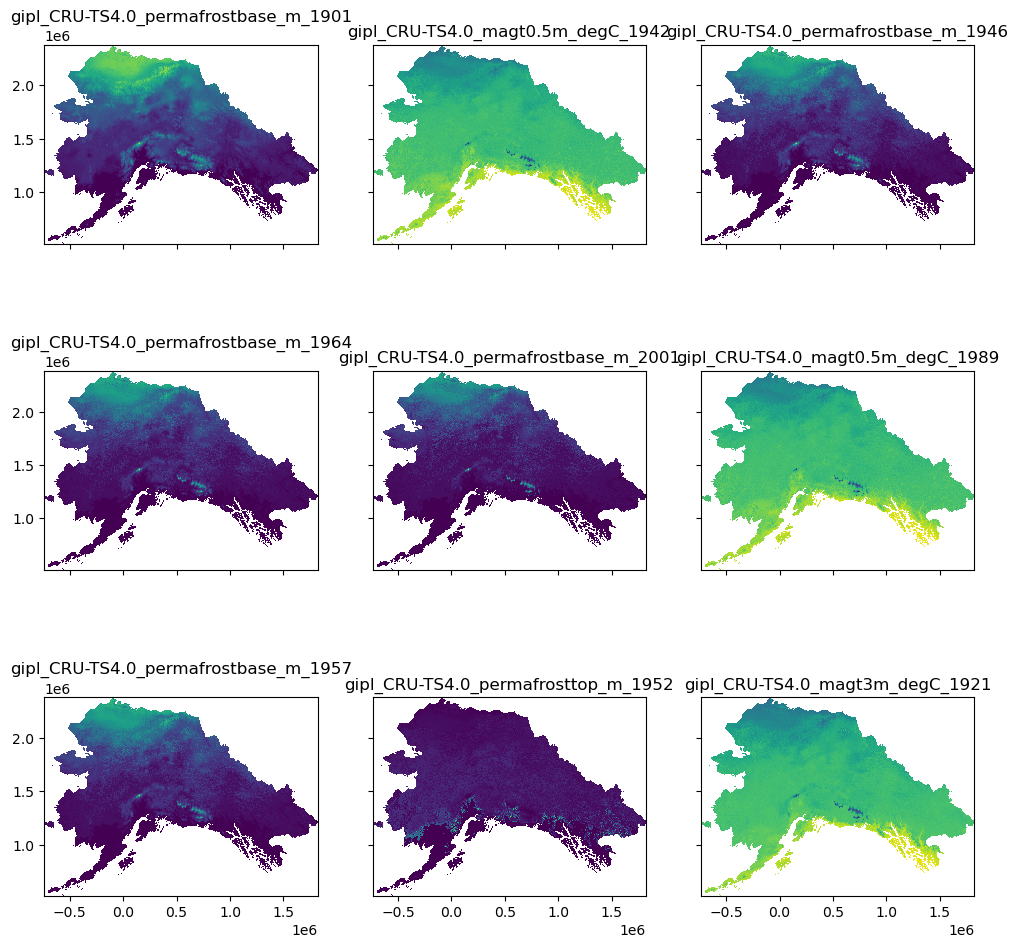

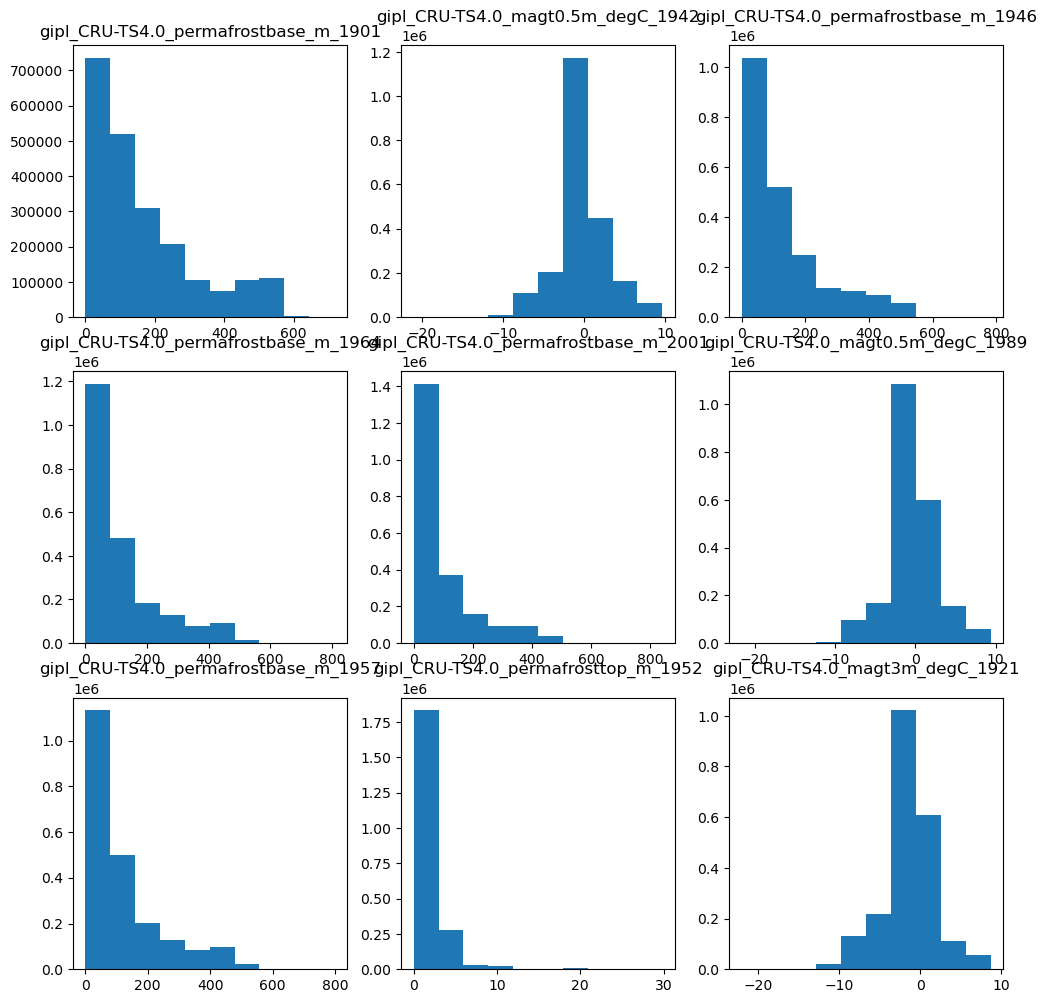

In [94]:
arrs, titles = plot_maps(processed)
plot_histograms(arrs, titles)

## Archive the QC'd data

Stash the data in the backed-up-Rasdaman-pot-of-SNAP-gold<sup>TM</sup>:`
/workspace/Shared/Tech_Projects/...` and while these GIPL outputs will hit the storefront in a few different ways (ARDAC, GeoNetwork Data Catalog, etc.) this is a good spot for right now because it will facilitate creating Rasdaman coverages.

In [96]:
import shutil
from pathlib import Path
from tqdm import tqdm

archive_path = Path("/workspace/Shared/Tech_Projects/GIPL_IEM/rasdaman_datasets")

archive_fps = [archive_path / ''.join(x.name) for x in processed]
print(f"Copying {len(archive_fps)} files to {archive_path}...")
for src, dst in zip(processed, archive_fps):
    shutil.copy(src, dst)
assert(len([x for x in archive_path.glob("*.tif")]) == len(processed))

Copying 1034 files to /workspace/Shared/Tech_Projects/GIPL_IEM/rasdaman_datasets...
